An example of using a defined footprint area (here, pulled from the scheduler definitions of different areas) to calculate a metric.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import sqlite3

import rubin_sim.maf as maf
from rubin_scheduler.scheduler.utils import SkyAreaGenerator, EuclidOverlapFootprint
from rubin_sim.data import get_baseline

In [2]:
# Pick up the "footprint of interest"
# The current survey footprint is defined in EuclidOverlapFootprint

nside=64
surveyAreas = EuclidOverlapFootprint(nside=nside)
map_footprints, map_labels = surveyAreas.return_maps()

In [3]:
# What areas are labelled in the map?
np.unique(map_labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'euclid_overlap', 'lowdust',
       'nes', 'scp', 'virgo'], dtype='<U20')

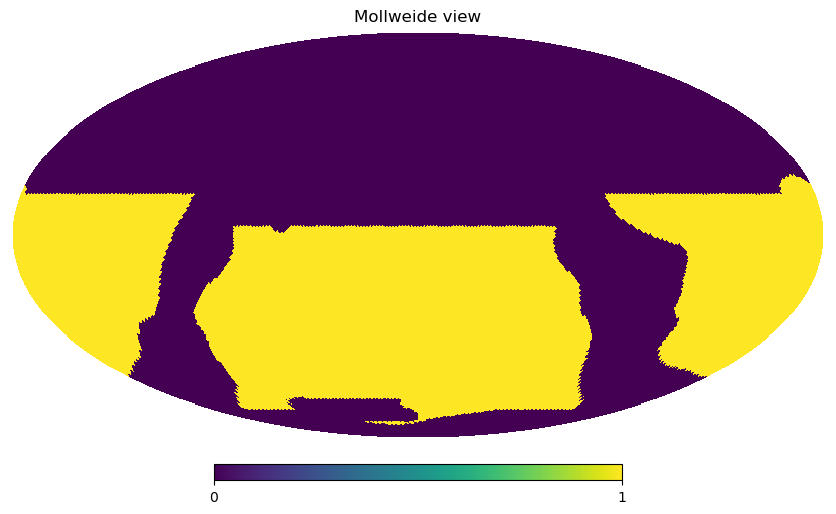

In [4]:
# Let's say the "area of interest" is the low-dust-extinction WFD 
# In practice, this likely includes the euclid_overlap and virgo areas which match lowdust in filter balance and visits
# (note that the bulge and LMC_SMC are also WFD-level in total # of visits)

lowdust = np.where((map_labels == 'lowdust') | (map_labels == 'euclid_overlap') | (map_labels == 'virgo'), 1, 0)
hp.mollview(lowdust)

In [5]:
# Let's just connect to the opsim output and check what "notes" are available too 
# We might want to reject or only include some subsets of visits due to survey mode

opsdb = get_baseline()
run_name = os.path.split(opsdb)[-1].replace('.db', '')
print(opsdb, '--', run_name)

/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v3.3_10yrs.db -- baseline_v3.3_10yrs


In [6]:
conn = sqlite3.connect(opsdb)
d = pd.read_sql('select distinct(note) from observations', conn)
conn.close()
d

,note
0,"blob_long, gr, a"
1,"blob_long, gr, b"
2,"pair_33, ug, a"
3,"pair_33, ug, b"
4,long
5,greedy
6,"twilight_near_sun, 0"
7,"twilight_near_sun, 1"
8,"twilight_near_sun, 2"
9,"twilight_near_sun, 3"


In [7]:
# Let's use these healpixels to calculate our metric -- using a HealpixSubsetSlicer
# Reject DDF and twilight near-sun visits (these are only 15s)

count_metric = maf.CountMetric(col='observationStartMJD', metric_name='NVisits')
depth_metric = maf.Coaddm5Metric()
slicer = maf.HealpixSubsetSlicer(nside=nside, hpid=np.where(map_labels == "lowdust")[0])
constraint = 'note not like "DD%" and note not like "%twi%"'

count_bundle = maf.MetricBundle(count_metric, slicer, constraint, run_name=run_name)
depth_bundle = maf.MetricBundle(depth_metric, slicer, constraint + " and filter == 'r'", run_name=run_name)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [8]:
g = maf.MetricBundleGroup({'count': count_bundle, 'depth': depth_bundle}, 
                          opsdb, 
                          out_dir='tmp_out', 
                          verbose=True)

In [9]:
g.run_all()

Querying table None with constraint note not like "DD%" and note not like "%twi%" for columns ['fieldDec', 'observationStartMJD', 'fieldRA', 'rotSkyPos']
Found 1934125 visits
Running:  ['count']
Processing slices:  43%|██████▍        | 20912/49152 [00:17<00:23, 1200.89it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying table None with constraint note not like "DD%" and note not like "%twi%" and filter == 'r' for columns ['fieldDec', 'fiveSigmaDepth', 'fieldRA', 'rotSkyPos']
Found 441236 visits
Running:  ['depth']
Processing slices:  43%|██████▍        | 20912/49152 [00:07<00:09, 2929.43it/s]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

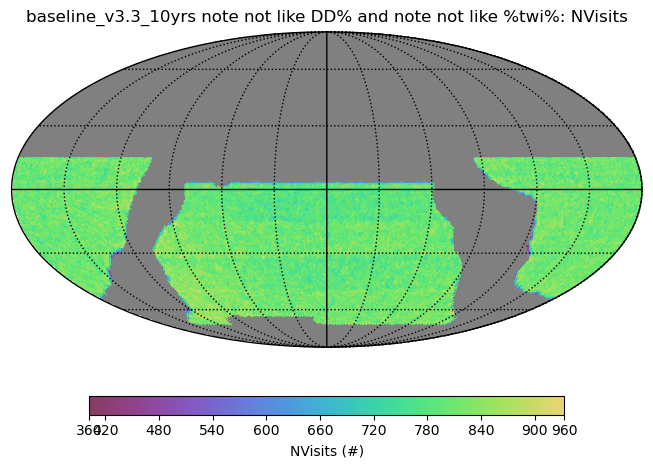

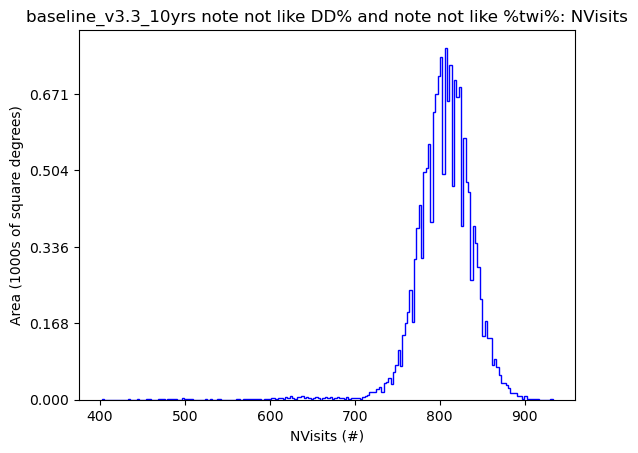

In [10]:
count_bundle.plot()

{'SkyMap': <Figure size 640x480 with 2 Axes>,
 'Histogram': <Figure size 640x480 with 1 Axes>}

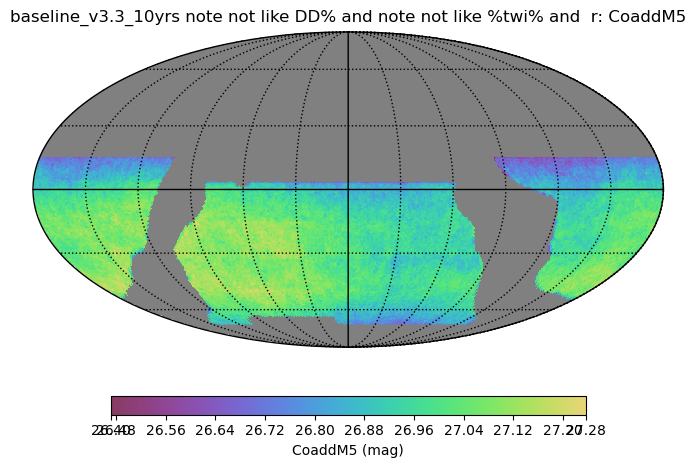

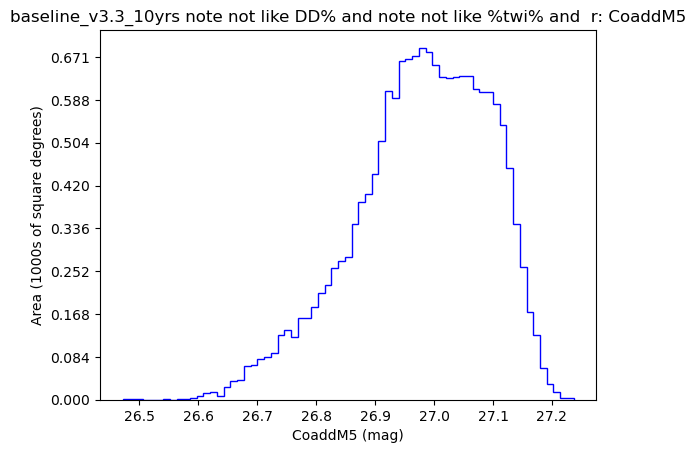

In [11]:
depth_bundle.plot()

In [12]:
count_bundle.set_summary_metrics(maf.extended_summary())
depth_bundle.set_summary_metrics(maf.extended_summary())

count_bundle.compute_summary_stats()
depth_bundle.compute_summary_stats()

In [13]:
pd.DataFrame([count_bundle.summary_values, depth_bundle.summary_values], index=['Count', 'r band depth'])

,Mean,Rms,Median,Max,Min,N(+3Sigma),N(-3Sigma),Count,25th%ile,75th%ile
Count,805.209067,35.378891,807.000000,933.000000,402.000000,4,231,20912,788.00000,826.000000
r band depth,26.977812,0.113538,26.987828,27.236769,26.471564,0,62,20912,26.90865,27.065635
